In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.linalg import toeplitz
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

In [15]:
#Data

asset_ticker = "AAPL"
market_ticker = "^GSPC"
risk_free_ticker = "^IRX"

start_date = "2020-01-01"
end_date = "2024-01-01"

In [16]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Download historical closing prices for asset, market, and risk-free rate
asset_data = yf.download(asset_ticker, start=start_date, end=end_date, progress=False)["Close"]  # Asset prices
market_data = yf.download(market_ticker, start=start_date, end=end_date, progress=False)["Close"]  # Market index prices
rf_data = yf.download(risk_free_ticker, start=start_date, end=end_date, progress=False)["Close"]  # Risk-free rate

# Compute daily returns for the asset and market
asset_returns = asset_data.pct_change().dropna()
market_returns = market_data.pct_change().dropna()

# Convert risk-free rate from percentage to decimal and align with asset returns
rf_returns = rf_data.shift(1).fillna(method="ffill") / 100  # Shift RF to avoid look-ahead bias
rf_returns = rf_returns.reindex(asset_returns.index).fillna(method="ffill")  # Align dates with asset returns

# Convert returns to Series (if needed)
asset_returns = asset_returns.squeeze()
market_returns = market_returns.squeeze() 
rf_returns = rf_returns.squeeze()  

# Compute **excess returns** (returns over risk-free rate)
excess_asset_returns = asset_returns - rf_returns  # Excess returns for the asset
excess_market_returns = market_returns - rf_returns  # Excess returns for the market


In [17]:
# Preparing the data for the Linear Regression

X = sm.add_constant(excess_market_returns)
y = excess_asset_returns  
X.columns = ["Constant", "Excess Market Returns"]

capm_model = sm.OLS(y, X).fit()

#Results

print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     4968.
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:46:06   Log-Likelihood:                 2985.5
No. Observations:                1005   AIC:                            -5967.
Df Residuals:                    1003   BIC:                            -5957.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Constant                  0.00

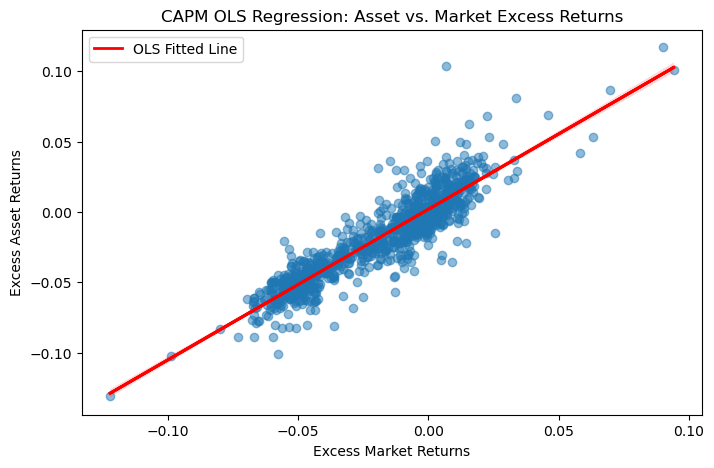

In [18]:
# Extract fitted values from the CAPM regression model
fitted_values = capm_model.fittedvalues

# Create a scatter plot with regression line
plt.figure(figsize=(8, 5))

# Scatter plot of excess asset returns vs. excess market returns
sns.regplot(
    x=excess_market_returns, 
    y=excess_asset_returns, 
    scatter_kws={'alpha': 0.5},  # Set transparency for better visibility
    line_kws={"color": "red"}  # Set regression line color
)

# Overlay the fitted regression line from OLS model
plt.plot(
    excess_market_returns, 
    fitted_values, 
    color="red", 
    linewidth=2, 
    label="OLS Fitted Line"
)

# Set axis labels and title
plt.xlabel("Excess Market Returns")
plt.ylabel("Excess Asset Returns")
plt.title("CAPM OLS Regression: Asset vs. Market Excess Returns")

# Display legend and show the plot
plt.legend()
plt.show()


In [ ]:
# Extract residuals from the CAPM regression model
residuals = pd.Series(capm_model.resid)

# Function to find the best ARIMA model based on AIC (Akaike Information Criterion)
def find_best_arima(data, p_range, d_range, q_range):
    best_aic = np.inf  # Initialize with a very large AIC value
    best_order = None  # Store the best (p, d, q) order
    best_model = None  # Store the best ARIMA model

    # Iterate over all possible combinations of p, d, and q
    for order in product(p_range, d_range, q_range):
        try:
            # Fit ARIMA model with current order
            model = ARIMA(data, order=order).fit()

            # Update best model if the current AIC is lower than the best found so far
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue  # Skip orders that cause errors

    return best_model, best_order  # Return the best ARIMA model and order

# Define the range of ARIMA hyperparameters (p, d, q)
p_range = range(0, 4)  # Autoregressive terms
d_range = range(0, 2)  # Differencing terms
q_range = range(0, 4)  # Moving average terms

# Suppress specific ARIMA-related warnings to avoid cluttered output
warnings.filterwarnings("ignore", message=".*A date index has been provided.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Non-stationary starting autoregressive parameters.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Non-invertible starting MA parameters found.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Maximum Likelihood optimization failed to converge.*")

# Find the best ARIMA model for CAPM residuals
model, best_order = find_best_arima(residuals, p_range, d_range, q_range)

# Print the best ARIMA order
print(f"Best ARIMA Order: {best_order}")


In [ ]:
import numpy as np
from scipy.linalg import toeplitz

# Extract variance (sigma²) from the fitted ARIMA model
sigma2 = model.scale 

# Extract AR and MA parameters from the model (handling cases with no parameters)
ar_params = model.arparams if model.arparams.size > 0 else np.array([])
ma_params = model.maparams if model.maparams.size > 0 else np.array([])

# Construct AR and MA polynomials (include leading 1 for stability)
ar_poly = np.r_[1, -ar_params] if ar_params.size else np.array([1])
ma_poly = np.r_[1, ma_params] if ma_params.size else np.array([1])

# Function to compute the autocovariance function (ACF) manually
def compute_acovf(ar, ma, sigma2, lags):
    """
    Compute the autocovariance function up to a given number of lags.

    Parameters:
    - ar: AR polynomial coefficients
    - ma: MA polynomial coefficients
    - sigma2: Residual variance (sigma²)
    - lags: Number of lags to compute

    Returns:
    - acovf: Autocovariance values up to 'lags'
    """
    acovf = np.zeros(lags)
    
    # Compute lag-0 variance (based on AR and MA terms)
    acovf[0] = sigma2 * (1 + np.sum(ma**2)) / (1 - np.sum(ar**2)) if np.sum(ar**2) < 1 else sigma2

    # Compute higher-lag autocovariances using recursion
    for lag in range(1, lags):
        ar_slice = ar[:min(lag, len(ar))]  # Select AR terms up to current lag
        acovf_slice = acovf[:lag][::-1]  # Reverse previous ACF values

        # Handle different array lengths by padding with zeros
        if len(ar_slice) != len(acovf_slice):
            diff = abs(len(ar_slice) - len(acovf_slice))
            if len(ar_slice) < len(acovf_slice):
                ar_slice = np.pad(ar_slice, (0, diff))
            else:
                acovf_slice = np.pad(acovf_slice, (0, diff))

        # Compute autocovariance using dot product
        acovf[lag] = np.dot(ar_slice, acovf_slice)

    return acovf

# Compute autocovariances up to the length of residuals
acovf = compute_acovf(ar_params, ma_params, sigma2, len(residuals))

# Construct the covariance matrix using the Toeplitz structure
cov_matrix = toeplitz(acovf)

# Validate covariance matrix properties
print("Covariance matrix shape:", cov_matrix.shape)

# Check for positive semi-definiteness (all eigenvalues should be non-negative)
min_eigenvalue = np.min(np.linalg.eigvalsh(cov_matrix))
print("Minimum eigenvalue:", min_eigenvalue)


Covariance matrix shape: (1005, 1005)
0.7531014768001746


In [ ]:
#GLS

capm_gls = sm.GLS(y, X, sigma=cov_matrix).fit()
print(capm_gls.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            GLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     5099.
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:39:54   Log-Likelihood:                 2990.5
No. Observations:                1005   AIC:                            -5977.
Df Residuals:                    1003   BIC:                            -5967.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Constant                  0.00

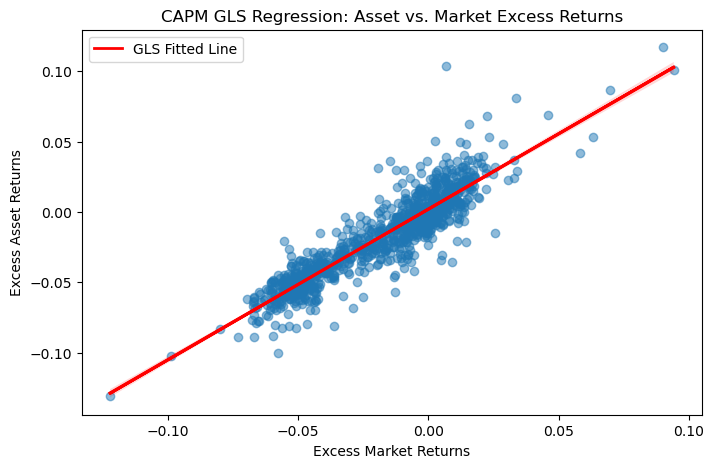

In [ ]:
# Extract fitted values from the Generalized Least Squares (GLS) CAPM regression model
fitted_values = capm_gls.fittedvalues

# Create a scatter plot with regression line
plt.figure(figsize=(8, 5))

sns.regplot(
    x=excess_market_returns, 
    y=excess_asset_returns, 
    scatter_kws={'alpha': 0.5}, 
    line_kws={"color": "red"}  
)
plt.plot(
    excess_market_returns, 
    fitted_values, 
    color="red", 
    linewidth=2, 
    label="GLS Fitted Line"
)

plt.xlabel("Excess Market Returns")
plt.ylabel("Excess Asset Returns")
plt.title("CAPM GLS Regression: Asset vs. Market Excess Returns")
plt.legend()
plt.show()
